# Pipeline Video de Production

**Module :** 04-Applications  
**Niveau :** Applications  
**Technologies :** OpenAI API, diffusers, moviepy, pydub, Pillow  
**Duree estimee :** 55 minutes  
**VRAM :** ~18 GB (optionnel, CPU possible pour l'essentiel)  

## Objectifs d'Apprentissage

- [ ] Generer un script video a partir d'un sujet avec un LLM
- [ ] Produire des images pour chaque scene (DALL-E ou generation locale)
- [ ] Animer les images avec des effets cinematographiques (zoom, pan, avec moviepy)
- [ ] Generer une narration vocale avec OpenAI TTS
- [ ] Creer des sous-titres synchronises a partir du texte de narration
- [ ] Assembler le pipeline complet : video + audio + sous-titres
- [ ] Evaluer la qualite avec des metriques de production

## Prerequis

- Python 3.10+
- Ensemble des notebooks Video 01-1 a 04-3
- Notebooks Audio (recommandes pour la partie TTS et sous-titres)
- Packages : `moviepy`, `Pillow`, `numpy`, `matplotlib`, `openai`, `pydub`
- Optionnel : `diffusers`, `torch` pour la generation d'images locale
- Cle API OpenAI pour TTS et generation de contenu

Ce notebook est le **point culminant** de la serie Video et fait reference
aux techniques des series Video et Audio.

**Navigation** : [<< 04-3 Sora API](04-3-Sora-API-Cloud-Video.ipynb) | [Audio 01-1 >>](../../Audio/01-Foundation/01-1-OpenAI-TTS-Intro.ipynb)

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres du pipeline
video_topic = "Intelligence Artificielle"  # Sujet de la video
video_width = 1280                 # Largeur video finale
video_height = 720                 # Hauteur video finale
video_fps = 30                     # FPS de la video finale
scene_duration = 8                 # Duree par scene (secondes)
output_format = "mp4"              # Format de sortie

# Options du pipeline
enable_llm_script = True           # Generer le script avec un LLM
enable_image_gen = True            # Generer les images des scenes
enable_animation = True            # Animer les images
enable_tts = True                  # Generer la narration TTS
enable_subtitles = True            # Generer les sous-titres
enable_assembly = True             # Assembler le tout
use_mock_api = True                # Utiliser des reponses simulees si API indisponible
save_results = True                # Sauvegarder les resultats

In [2]:
# Parameters
notebook_mode = "batch"
skip_widgets = True


In [3]:
# Setup environnement et imports
import os
import sys
import json
import time
import math
import struct
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Resolution GENAI_ROOT
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.video_helpers import get_video_info, extract_frames, display_frame_grid
        print("Helpers video importes")
    except ImportError as e:
        print(f"Helpers video non disponibles ({e}) - mode autonome")

# Repertoire de sortie
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PIPELINE_DIR = OUTPUT_DIR / 'pipeline'
PIPELINE_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('production_pipeline')

print(f"Pipeline Video de Production")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Sujet : {video_topic}")
print(f"Video : {video_width}x{video_height} @ {video_fps}fps")
print(f"Sortie : {PIPELINE_DIR}")

Helpers video importes
Pipeline Video de Production
Date : 2026-02-26 08:12:03
Mode : batch
Sujet : Intelligence Artificielle
Video : 1280x720 @ 30fps
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\video\pipeline


In [4]:
# Chargement .env et verification des dependances
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification des dependances
print("\n--- VERIFICATION DES DEPENDANCES ---")
print("=" * 40)

dependencies = {}

try:
    import moviepy.editor as mpy
    dependencies['moviepy'] = True
    print(f"moviepy : disponible")
except ImportError:
    dependencies['moviepy'] = False
    print(f"moviepy : NON INSTALLE (pip install moviepy)")

try:
    import imageio
    dependencies['imageio'] = True
    print(f"imageio : disponible")
except ImportError:
    dependencies['imageio'] = False
    print(f"imageio : NON INSTALLE")

try:
    from openai import OpenAI
    dependencies['openai'] = True
    print(f"openai : disponible")
except ImportError:
    dependencies['openai'] = False
    print(f"openai : NON INSTALLE (pip install openai)")

try:
    from pydub import AudioSegment
    dependencies['pydub'] = True
    print(f"pydub : disponible")
except ImportError:
    dependencies['pydub'] = False
    print(f"pydub : NON INSTALLE (pip install pydub)")

try:
    import diffusers
    import torch
    dependencies['diffusers'] = True
    gpu_available = torch.cuda.is_available()
    print(f"diffusers : disponible (GPU: {gpu_available})")
except ImportError:
    dependencies['diffusers'] = False
    print(f"diffusers : NON INSTALLE (optionnel)")

# Verifier cle OpenAI
openai_key = os.environ.get('OPENAI_API_KEY', '')
openai_base = os.environ.get('OPENAI_BASE_URL', '')
api_available = bool(openai_key and dependencies.get('openai', False))

print(f"\nAPI OpenAI : {'disponible' if api_available else 'non disponible'}")
print(f"Mode mock : {use_mock_api or not api_available}")

available_count = sum(dependencies.values())
total_count = len(dependencies)
print(f"Dependances disponibles : {available_count}/{total_count}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- VERIFICATION DES DEPENDANCES ---
moviepy : NON INSTALLE (pip install moviepy)
imageio : disponible


openai : disponible
pydub : disponible


C:\Users\jsboi\AppData\Roaming\Python\Python313\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


diffusers : disponible (GPU: False)

API OpenAI : disponible
Mode mock : True
Dependances disponibles : 4/5


## Etape 1 : Generation du script video avec LLM

Le pipeline commence par la generation d'un script structure.
Un LLM (GPT-4 ou equivalent) produit une liste de scenes avec :
- Description visuelle (pour la generation d'images)
- Texte de narration (pour le TTS)
- Instructions de camera (pour l'animation)

In [5]:
# Etape 1 : Generation du script
print("\n--- ETAPE 1 : GENERATION DU SCRIPT ---")
print("=" * 45)


def generate_script_with_llm(topic: str) -> List[dict]:
    """Genere un script video a partir d'un sujet en utilisant l'API OpenAI."""
    if api_available and not use_mock_api:
        try:
            client_kwargs = {'api_key': openai_key}
            if openai_base:
                client_kwargs['base_url'] = openai_base
            client = OpenAI(**client_kwargs)
            
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": (
                        "Tu es un scenariste de videos educatives. "
                        "Genere un script structure en JSON avec 5 scenes. "
                        "Chaque scene a : title, visual_description, narration, camera_motion. "
                        "Reponds uniquement avec le JSON."
                    )},
                    {"role": "user", "content": f"Cree un script video sur : {topic}"}
                ],
                temperature=0.7,
                max_tokens=1500,
            )
            
            content = response.choices[0].message.content
            # Extraire le JSON de la reponse
            if '```json' in content:
                content = content.split('```json')[1].split('```')[0]
            elif '```' in content:
                content = content.split('```')[1].split('```')[0]
            
            scenes = json.loads(content)
            if isinstance(scenes, dict) and 'scenes' in scenes:
                scenes = scenes['scenes']
            return scenes
        except Exception as e:
            print(f"Erreur API LLM : {type(e).__name__} - {str(e)[:80]}")
            print("Utilisation du script par defaut")
    
    # Script par defaut (mode demo)
    return [
        {
            "title": "Introduction",
            "visual_description": "Un reseau de neurones lumineux sur fond sombre, "
                                  "avec des connexions qui s'illuminent progressivement",
            "narration": f"Bienvenue dans cette exploration de l'{topic}. "
                         f"Nous allons decouvrir comment cette technologie transforme notre monde.",
            "camera_motion": "zoom_in",
        },
        {
            "title": "Origines historiques",
            "visual_description": "Une frise chronologique avec des portraits de pionniers "
                                  "de l'IA : Turing, McCarthy, Minsky",
            "narration": f"L'{topic} trouve ses racines dans les annees 1950, "
                         f"avec les travaux fondateurs d'Alan Turing et de John McCarthy.",
            "camera_motion": "pan_right",
        },
        {
            "title": "Fonctionnement",
            "visual_description": "Schema anime montrant des donnees qui traversent "
                                  "les couches d'un reseau de neurones profond",
            "narration": "Les systemes modernes reposent sur des reseaux de neurones "
                         "profonds qui apprennent a partir de milliards d'exemples.",
            "camera_motion": "slow_zoom",
        },
        {
            "title": "Applications",
            "visual_description": "Montage d'applications : voiture autonome, diagnostic medical, "
                                  "assistant vocal, traduction automatique",
            "narration": f"Aujourd'hui, l'{topic} est presente partout : des voitures autonomes "
                         f"aux assistants vocaux, en passant par la medecine et la traduction.",
            "camera_motion": "pan_left",
        },
        {
            "title": "Perspectives",
            "visual_description": "Vue futuriste d'une ville connectee avec des flux "
                                  "de donnees visibles dans le ciel",
            "narration": "L'avenir nous reserve des avancees encore plus spectaculaires. "
                         "La question n'est plus si, mais comment nous guiderons cette revolution.",
            "camera_motion": "zoom_out",
        },
    ]


# Generer le script
script_scenes = generate_script_with_llm(video_topic)

print(f"Script genere : {len(script_scenes)} scenes")
print(f"Duree totale estimee : {len(script_scenes) * scene_duration}s")
print(f"\nResume du script :")
for i, scene in enumerate(script_scenes):
    print(f"  Scene {i+1} : {scene['title']}")
    print(f"    Visuel : {scene['visual_description'][:60]}...")
    print(f"    Narration : {scene['narration'][:60]}...")
    print(f"    Camera : {scene['camera_motion']}")


--- ETAPE 1 : GENERATION DU SCRIPT ---
Script genere : 5 scenes
Duree totale estimee : 40s

Resume du script :
  Scene 1 : Introduction
    Visuel : Un reseau de neurones lumineux sur fond sombre, avec des con...
    Narration : Bienvenue dans cette exploration de l'Intelligence Artificie...
    Camera : zoom_in
  Scene 2 : Origines historiques
    Visuel : Une frise chronologique avec des portraits de pionniers de l...
    Narration : L'Intelligence Artificielle trouve ses racines dans les anne...
    Camera : pan_right
  Scene 3 : Fonctionnement
    Visuel : Schema anime montrant des donnees qui traversent les couches...
    Narration : Les systemes modernes reposent sur des reseaux de neurones p...
    Camera : slow_zoom
  Scene 4 : Applications
    Visuel : Montage d'applications : voiture autonome, diagnostic medica...
    Narration : Aujourd'hui, l'Intelligence Artificielle est presente partou...
    Camera : pan_left
  Scene 5 : Perspectives
    Visuel : Vue futuriste d'une vil

### Interpretation : Generation du script

| Element du script | Role dans le pipeline |
|-------------------|----------------------|
| `title` | Identifiant de la scene, sous-titrage des chapitres |
| `visual_description` | Prompt pour la generation d'images (DALL-E ou local) |
| `narration` | Texte pour le TTS (voix off) et les sous-titres |
| `camera_motion` | Instruction d'animation (zoom, pan, etc.) |

**Points cles** :
1. Le script structure sert de plan directeur pour toutes les etapes suivantes
2. La qualite du prompt LLM influence directement la coherence de la video finale
3. Un bon script equilibre la duree des narrations avec le temps d'affichage des visuels

## Etape 2 : Generation des images de chaque scene

A partir des descriptions visuelles du script, nous generons une image
representant chaque scene. En production, on utiliserait DALL-E 3 ou
un modele local comme SDXL. Ici, nous generons des images stylisees avec Pillow.


--- ETAPE 2 : GENERATION DES IMAGES ---
  Scene 1 : Introduction - Image generee
  Scene 2 : Origines historiques - Image generee
  Scene 3 : Fonctionnement - Image generee
  Scene 4 : Applications - Image generee
  Scene 5 : Perspectives - Image generee

5 images generees (1280x720)


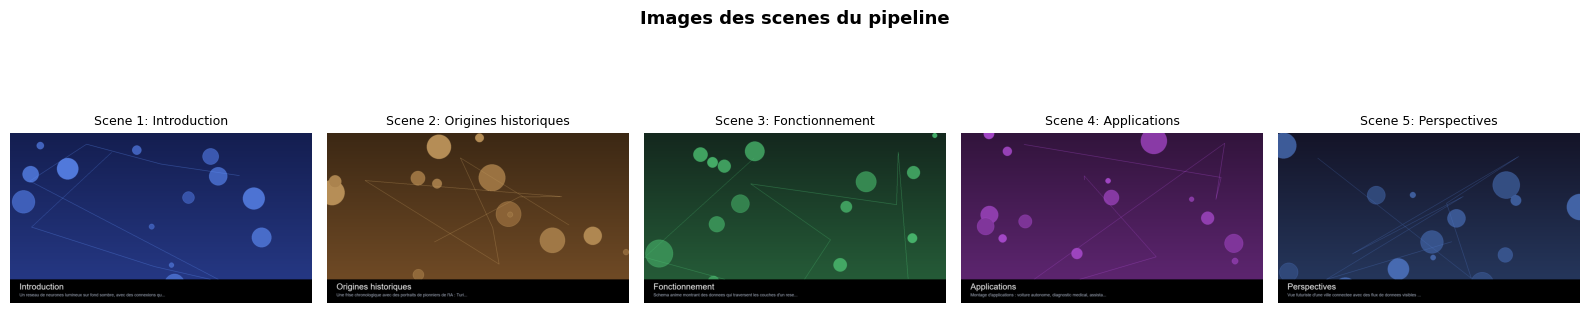

In [6]:
# Etape 2 : Generation des images
print("\n--- ETAPE 2 : GENERATION DES IMAGES ---")
print("=" * 45)


def generate_scene_image(scene: dict, width: int, height: int,
                         scene_idx: int) -> Image.Image:
    """
    Genere une image representative pour une scene.
    En mode demo, utilise Pillow pour un rendu stylise.
    En production, utiliserait DALL-E 3 ou SDXL.
    """
    img = Image.new('RGB', (width, height))
    draw = ImageDraw.Draw(img)
    rng = np.random.RandomState(scene_idx * 42)
    
    # Palette de couleurs par scene
    palettes = [
        [(20, 30, 80), (40, 60, 140), (100, 150, 255)],    # Bleu tech
        [(60, 40, 20), (120, 80, 40), (200, 160, 100)],    # Sepia historique
        [(20, 40, 30), (40, 100, 60), (80, 200, 120)],     # Vert data
        [(50, 20, 60), (100, 40, 120), (180, 80, 220)],    # Violet innovation
        [(20, 20, 40), (40, 60, 100), (80, 120, 200)],     # Bleu futuriste
    ]
    palette = palettes[scene_idx % len(palettes)]
    
    # Fond gradient
    for y in range(height):
        ratio = y / height
        r = int(palette[0][0] * (1 - ratio) + palette[1][0] * ratio)
        g = int(palette[0][1] * (1 - ratio) + palette[1][1] * ratio)
        b = int(palette[0][2] * (1 - ratio) + palette[1][2] * ratio)
        draw.line([(0, y), (width, y)], fill=(r, g, b))
    
    # Formes decoratives (abstraction de la description)
    for _ in range(15):
        cx = rng.randint(0, width)
        cy = rng.randint(0, height)
        radius = rng.randint(10, 60)
        alpha = rng.uniform(0.2, 0.8)
        color = tuple(int(c * alpha + palette[2][i] * (1 - alpha))
                      for i, c in enumerate(palette[1]))
        draw.ellipse([cx - radius, cy - radius, cx + radius, cy + radius],
                     fill=color, outline=palette[2])
    
    # Lignes de connexion (style reseau)
    points = [(rng.randint(0, width), rng.randint(0, height)) for _ in range(8)]
    for i in range(len(points) - 1):
        draw.line([points[i], points[i + 1]], fill=palette[2], width=1)
    
    # Titre de la scene
    try:
        font_title = ImageFont.truetype("arial.ttf", 36)
        font_sub = ImageFont.truetype("arial.ttf", 18)
    except (OSError, IOError):
        font_title = ImageFont.load_default()
        font_sub = ImageFont.load_default()
    
    # Bandeau titre
    draw.rectangle([0, height - 100, width, height], fill=(0, 0, 0, 180))
    draw.text((40, height - 90), scene['title'], fill=(255, 255, 255), font=font_title)
    desc_short = scene['visual_description'][:70] + '...'
    draw.text((40, height - 45), desc_short, fill=(180, 190, 210), font=font_sub)
    
    return img


# Generer les images
scene_images = []
for i, scene in enumerate(script_scenes):
    img = generate_scene_image(scene, video_width, video_height, i)
    scene_images.append(img)
    
    if save_results:
        img_path = PIPELINE_DIR / f"scene_{i+1:02d}.png"
        img.save(str(img_path))
    
    print(f"  Scene {i+1} : {scene['title']} - Image generee")

print(f"\n{len(scene_images)} images generees ({video_width}x{video_height})")

# Apercu en grille
n_scenes = len(scene_images)
cols = min(n_scenes, 5)
fig, axes = plt.subplots(1, cols, figsize=(16, 4))
if cols == 1:
    axes = [axes]
for i in range(cols):
    axes[i].imshow(scene_images[i])
    axes[i].set_title(f"Scene {i+1}: {script_scenes[i]['title']}", fontsize=9)
    axes[i].axis('off')
plt.suptitle("Images des scenes du pipeline", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Etape 3 : Animation des images

Chaque image statique est transformee en sequence animee avec un mouvement
de camera cinematographique : zoom avant/arriere, panoramique gauche/droite.
Ces effets, connus sous le nom d'"effets Ken Burns", donnent vie aux images fixes.

In [7]:
# Etape 3 : Animation des images avec effets camera
if enable_animation:
    print("\n--- ETAPE 3 : ANIMATION DES IMAGES ---")
    print("=" * 45)
    
    def animate_image(image: Image.Image, motion: str, duration: float,
                      fps: int) -> List[np.ndarray]:
        """
        Anime une image avec un mouvement de camera.
        
        Mouvements : zoom_in, zoom_out, pan_left, pan_right, slow_zoom
        """
        w, h = image.size
        n_frames = int(duration * fps)
        frames = []
        
        # Precharger l'image en haute resolution pour le zoom
        scale_factor = 1.3
        img_large = image.resize((int(w * scale_factor), int(h * scale_factor)), Image.LANCZOS)
        lw, lh = img_large.size
        
        for i in range(n_frames):
            t = i / max(n_frames - 1, 1)
            ease_t = t * t * (3 - 2 * t)  # Smoothstep easing
            
            if motion == "zoom_in":
                zoom = 1.0 + 0.25 * ease_t
                crop_w = int(w / zoom)
                crop_h = int(h / zoom)
                left = (w - crop_w) // 2
                top = (h - crop_h) // 2
                frame = image.crop((left, top, left + crop_w, top + crop_h))
                frame = frame.resize((w, h), Image.LANCZOS)
            
            elif motion == "zoom_out":
                zoom = 1.25 - 0.25 * ease_t
                crop_w = int(lw / zoom)
                crop_h = int(lh / zoom)
                left = (lw - crop_w) // 2
                top = (lh - crop_h) // 2
                frame = img_large.crop((left, top, left + crop_w, top + crop_h))
                frame = frame.resize((w, h), Image.LANCZOS)
            
            elif motion == "pan_right":
                offset = int((lw - w) * ease_t)
                frame = img_large.crop((offset, (lh - h) // 2,
                                        offset + w, (lh - h) // 2 + h))
            
            elif motion == "pan_left":
                offset = int((lw - w) * (1 - ease_t))
                frame = img_large.crop((offset, (lh - h) // 2,
                                        offset + w, (lh - h) // 2 + h))
            
            elif motion == "slow_zoom":
                zoom = 1.0 + 0.1 * ease_t
                crop_w = int(w / zoom)
                crop_h = int(h / zoom)
                left = (w - crop_w) // 2
                top = (h - crop_h) // 2
                frame = image.crop((left, top, left + crop_w, top + crop_h))
                frame = frame.resize((w, h), Image.LANCZOS)
            
            else:
                frame = image  # Pas de mouvement
            
            frames.append(np.array(frame))
        
        return frames
    
    # Animer toutes les scenes
    animated_scenes = []
    total_frames = 0
    
    for i, (image, scene) in enumerate(zip(scene_images, script_scenes)):
        motion = scene.get('camera_motion', 'slow_zoom')
        scene_frames = animate_image(image, motion, scene_duration, video_fps)
        animated_scenes.append(scene_frames)
        total_frames += len(scene_frames)
        print(f"  Scene {i+1} : {scene['title']} - {len(scene_frames)} frames ({motion})")
    
    print(f"\nTotal frames animees : {total_frames}")
    print(f"Duree totale : {total_frames / video_fps:.1f}s")
else:
    # Pas d'animation : frames statiques
    animated_scenes = []
    for image in scene_images:
        static = [np.array(image)] * (scene_duration * video_fps)
        animated_scenes.append(static)
    print("Animation desactivee - frames statiques")


--- ETAPE 3 : ANIMATION DES IMAGES ---


  Scene 1 : Introduction - 240 frames (zoom_in)


  Scene 2 : Origines historiques - 240 frames (pan_right)


  Scene 3 : Fonctionnement - 240 frames (slow_zoom)


  Scene 4 : Applications - 240 frames (pan_left)


  Scene 5 : Perspectives - 240 frames (zoom_out)

Total frames animees : 1200
Duree totale : 40.0s


## Etape 4 : Generation de la narration TTS

La narration vocale est generee a partir du texte de chaque scene avec OpenAI TTS.
En mode demonstration, nous generons un signal audio synthetique (ton sinusoidal)
de la bonne duree pour simuler la narration.

In [8]:
# Etape 4 : Generation de la narration TTS
if enable_tts:
    print("\n--- ETAPE 4 : GENERATION NARRATION TTS ---")
    print("=" * 50)
    
    def generate_tts_audio(text: str, scene_idx: int,
                           target_duration: float) -> Tuple[np.ndarray, int]:
        """
        Genere l'audio TTS pour une scene.
        Retourne (audio_samples, sample_rate).
        """
        sample_rate = 22050
        
        if api_available and not use_mock_api:
            try:
                client_kwargs = {'api_key': openai_key}
                if openai_base:
                    client_kwargs['base_url'] = openai_base
                client = OpenAI(**client_kwargs)
                
                response = client.audio.speech.create(
                    model="tts-1",
                    voice="nova",
                    input=text,
                    response_format="wav",
                )
                
                audio_path = PIPELINE_DIR / f"narration_{scene_idx:02d}.wav"
                response.stream_to_file(str(audio_path))
                
                if dependencies.get('pydub', False):
                    audio_seg = AudioSegment.from_wav(str(audio_path))
                    samples = np.array(audio_seg.get_array_of_samples(), dtype=np.float32)
                    samples = samples / max(abs(samples.max()), abs(samples.min()), 1)
                    return samples, audio_seg.frame_rate
            except Exception as e:
                print(f"    Erreur TTS API : {type(e).__name__} - {str(e)[:60]}")
        
        # Mode demonstration : generer un signal audio synthetique
        n_samples = int(target_duration * sample_rate)
        t_arr = np.linspace(0, target_duration, n_samples)
        
        # Simuler la prosodie de la parole avec des modulations
        base_freq = 150 + scene_idx * 10  # Frequence de base variable
        # Modulation de frequence pour simuler l'intonation
        freq_mod = base_freq + 30 * np.sin(2 * np.pi * 0.5 * t_arr)
        # Signal avec enveloppe
        phase = 2 * np.pi * np.cumsum(freq_mod) / sample_rate
        signal = 0.3 * np.sin(phase)
        # Enveloppe : fade in/out
        envelope = np.ones(n_samples)
        fade_len = int(0.1 * sample_rate)
        envelope[:fade_len] = np.linspace(0, 1, fade_len)
        envelope[-fade_len:] = np.linspace(1, 0, fade_len)
        signal = signal * envelope
        
        return signal.astype(np.float32), sample_rate
    
    # Generer la narration pour chaque scene
    narration_audio = []
    narration_texts = []
    
    for i, scene in enumerate(script_scenes):
        text = scene['narration']
        narration_texts.append(text)
        
        audio_data, sr = generate_tts_audio(text, i, scene_duration)
        narration_audio.append((audio_data, sr))
        
        duration_actual = len(audio_data) / sr
        print(f"  Scene {i+1} : {duration_actual:.1f}s audio "
              f"({len(text)} chars, {sr}Hz)")
    
    # Concatener tout l'audio
    combined_sr = narration_audio[0][1]
    combined_audio = np.concatenate([a[0] for a in narration_audio])
    total_audio_duration = len(combined_audio) / combined_sr
    
    print(f"\nAudio total : {total_audio_duration:.1f}s, {combined_sr}Hz")
    print(f"Echantillons : {len(combined_audio)}")
    
    # Sauvegarder l'audio combine en WAV
    if save_results:
        combined_audio_path = PIPELINE_DIR / "narration_combined.wav"
        # Ecriture WAV simple
        audio_int16 = (combined_audio * 32767).astype(np.int16)
        import wave
        with wave.open(str(combined_audio_path), 'w') as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(2)
            wav_file.setframerate(combined_sr)
            wav_file.writeframes(audio_int16.tobytes())
        print(f"Audio sauvegarde : {combined_audio_path.name} "
              f"({combined_audio_path.stat().st_size / 1024:.0f} KB)")
else:
    narration_audio = []
    narration_texts = [s['narration'] for s in script_scenes]
    print("TTS desactive")


--- ETAPE 4 : GENERATION NARRATION TTS ---
  Scene 1 : 8.0s audio (136 chars, 22050Hz)
  Scene 2 : 8.0s audio (131 chars, 22050Hz)
  Scene 3 : 8.0s audio (116 chars, 22050Hz)
  Scene 4 : 8.0s audio (154 chars, 22050Hz)
  Scene 5 : 8.0s audio (135 chars, 22050Hz)

Audio total : 40.0s, 22050Hz
Echantillons : 882000
Audio sauvegarde : narration_combined.wav (1723 KB)


## Etape 5 : Sous-titres et assemblage final

Les sous-titres sont generes a partir du texte de narration avec un timing
synchronise sur chaque scene. L'assemblage final combine video + audio + sous-titres
en un seul fichier MP4.

In [9]:
# Etape 5 : Sous-titres et assemblage final
print("\n--- ETAPE 5 : SOUS-TITRES ET ASSEMBLAGE ---")
print("=" * 50)

# Generation des sous-titres
if enable_subtitles:
    print("Generation des sous-titres...")
    
    def generate_srt(scenes: List[dict], duration_per_scene: float) -> str:
        """Genere un fichier SRT a partir des textes de narration."""
        srt_content = ""
        for i, scene in enumerate(scenes):
            start_time = i * duration_per_scene
            end_time = (i + 1) * duration_per_scene
            
            # Formater en HH:MM:SS,mmm
            def fmt_time(seconds):
                h = int(seconds // 3600)
                m = int((seconds % 3600) // 60)
                s = int(seconds % 60)
                ms = int((seconds % 1) * 1000)
                return f"{h:02d}:{m:02d}:{s:02d},{ms:03d}"
            
            # Decouper le texte en segments de ~60 caracteres
            text = scene['narration']
            words = text.split()
            lines = []
            current_line = ""
            for word in words:
                if len(current_line) + len(word) + 1 > 60:
                    lines.append(current_line)
                    current_line = word
                else:
                    current_line = f"{current_line} {word}".strip()
            if current_line:
                lines.append(current_line)
            
            # Repartir le temps entre les lignes
            time_per_line = duration_per_scene / max(len(lines), 1)
            for j, line in enumerate(lines):
                sub_start = start_time + j * time_per_line
                sub_end = sub_start + time_per_line
                sub_idx = i * 10 + j + 1  # Index unique
                srt_content += f"{sub_idx}\n"
                srt_content += f"{fmt_time(sub_start)} --> {fmt_time(sub_end)}\n"
                srt_content += f"{line}\n\n"
        
        return srt_content
    
    srt_text = generate_srt(script_scenes, scene_duration)
    
    if save_results:
        srt_path = PIPELINE_DIR / "subtitles.srt"
        srt_path.write_text(srt_text, encoding='utf-8')
        print(f"Sous-titres sauvegardes : {srt_path.name}")
    
    # Afficher un extrait
    print(f"\nExtrait SRT (3 premières entrees) :")
    srt_lines = srt_text.strip().split('\n\n')[:3]
    for block in srt_lines:
        print(f"  {block}")

# Assemblage final : ajouter les sous-titres aux frames
print("\nAssemblage video avec sous-titres incrustes...")

def burn_subtitle(frame: np.ndarray, text: str,
                  width: int, height: int) -> np.ndarray:
    """Incruste un sous-titre en bas de la frame."""
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    
    try:
        font = ImageFont.truetype("arial.ttf", 22)
    except (OSError, IOError):
        font = ImageFont.load_default()
    
    # Fond semi-transparent pour le sous-titre
    bbox = draw.textbbox((0, 0), text, font=font)
    tw = bbox[2] - bbox[0]
    th = bbox[3] - bbox[1]
    x = (width - tw) // 2
    y = height - 70
    
    # Rectangle de fond
    padding = 8
    draw.rectangle(
        [x - padding, y - padding, x + tw + padding, y + th + padding],
        fill=(0, 0, 0)
    )
    draw.text((x, y), text, fill=(255, 255, 255), font=font)
    
    return np.array(img)


# Assembler toutes les scenes avec transitions et sous-titres
final_frames = []
transition_frames_count = int(0.5 * video_fps)  # 0.5s de fondu entre scenes

for scene_idx, (scene_frames, scene_data) in enumerate(zip(animated_scenes, script_scenes)):
    text = scene_data['narration']
    # Decouper le texte pour les sous-titres
    words = text.split()
    mid = len(words) // 2
    sub_parts = [' '.join(words[:mid]), ' '.join(words[mid:])]
    
    for f_idx, frame in enumerate(scene_frames):
        # Choisir la partie de sous-titre
        part_idx = 0 if f_idx < len(scene_frames) // 2 else 1
        if enable_subtitles and sub_parts[part_idx]:
            # Limiter la longueur du sous-titre
            sub_text = sub_parts[part_idx][:70]
            frame = burn_subtitle(frame, sub_text, video_width, video_height)
        final_frames.append(frame)
    
    # Transition fondu vers la scene suivante
    if scene_idx < len(animated_scenes) - 1:
        last_frame = scene_frames[-1]
        next_first = animated_scenes[scene_idx + 1][0]
        for t_idx in range(transition_frames_count):
            alpha = t_idx / max(transition_frames_count - 1, 1)
            blended = ((1 - alpha) * last_frame.astype(np.float32) +
                       alpha * next_first.astype(np.float32)).astype(np.uint8)
            final_frames.append(blended)

print(f"Frames finales : {len(final_frames)}")
print(f"Duree video : {len(final_frames) / video_fps:.1f}s")


--- ETAPE 5 : SOUS-TITRES ET ASSEMBLAGE ---
Generation des sous-titres...
Sous-titres sauvegardes : subtitles.srt

Extrait SRT (3 premières entrees) :
  1
00:00:00,000 --> 00:00:02,666
Bienvenue dans cette exploration de l'Intelligence
  2
00:00:02,666 --> 00:00:05,333
Artificielle. Nous allons decouvrir comment cette
  3
00:00:05,333 --> 00:00:08,000
technologie transforme notre monde.

Assemblage video avec sous-titres incrustes...


Frames finales : 1260
Duree video : 42.0s



--- EXPORT VIDEO FINALE ---


Video exportee : production_video.mp4
  Resolution : 1280x720
  FPS : 30
  Duree : 42.0s
  Taille : 2.89 MB
  Temps d'export : 4.09s


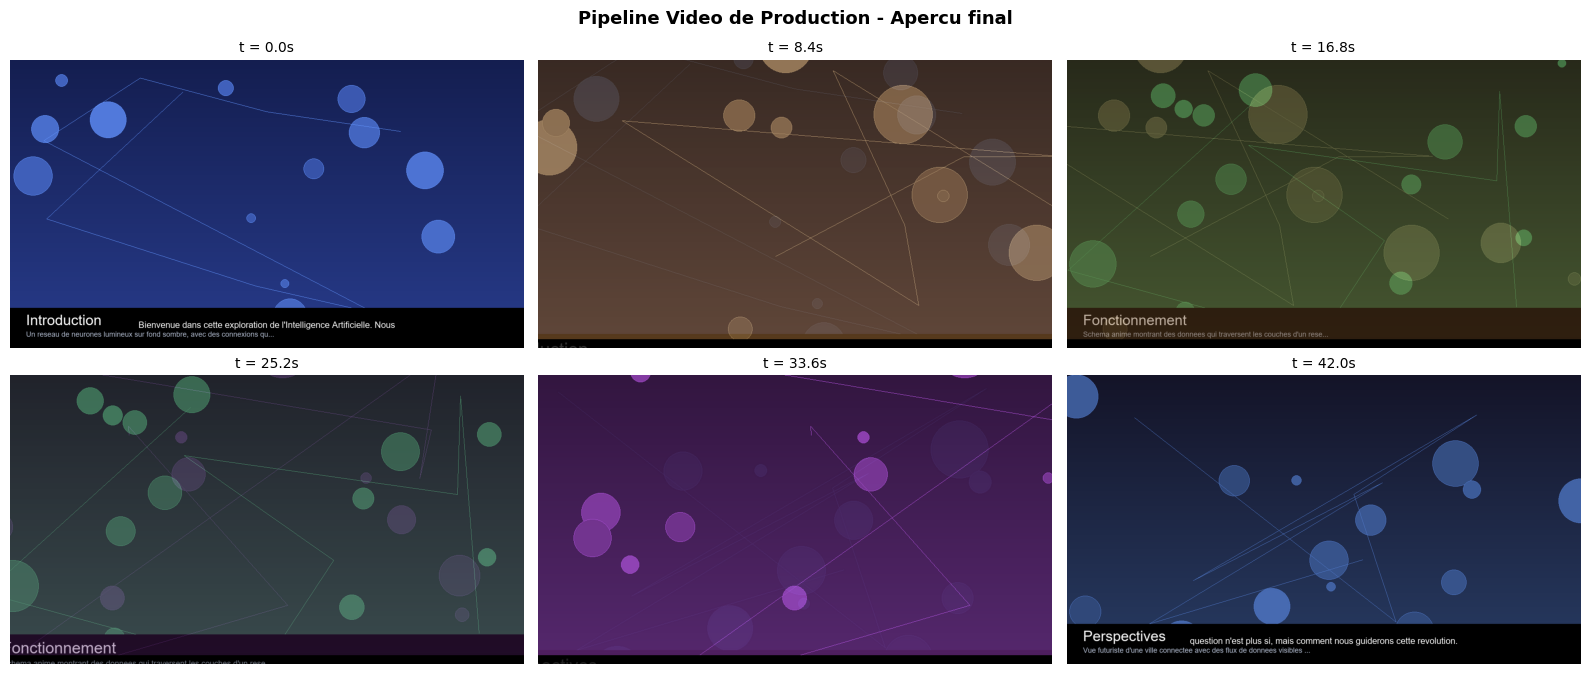


--- METRIQUES DE QUALITE ---
Metrique                  Valeur                        
-------------------------------------------------------
  Scenes                  5                             
  Duree totale            42.0s                         
  Resolution              1280x720                      
  FPS                     30                            
  Frames totales          1260                          
  Taille fichier          2.89 MB                       
  Sous-titres             Oui                           
  Narration audio         Oui                           
  Animations camera       Oui                           
  Transitions             4 fondus                      


In [10]:
# Export de la video finale
print("\n--- EXPORT VIDEO FINALE ---")
print("=" * 40)

final_video_path = PIPELINE_DIR / f"production_video.{output_format}"

if dependencies.get('imageio', False):
    start_time = time.time()
    
    writer = imageio.get_writer(
        str(final_video_path), fps=video_fps, codec='libx264',
        output_params=['-crf', '20', '-preset', 'medium']
    )
    for frame in final_frames:
        writer.append_data(frame)
    writer.close()
    
    export_time = time.time() - start_time
    file_size_mb = final_video_path.stat().st_size / (1024 * 1024)
    
    print(f"Video exportee : {final_video_path.name}")
    print(f"  Resolution : {video_width}x{video_height}")
    print(f"  FPS : {video_fps}")
    print(f"  Duree : {len(final_frames) / video_fps:.1f}s")
    print(f"  Taille : {file_size_mb:.2f} MB")
    print(f"  Temps d'export : {export_time:.2f}s")
    
    # Apercu final
    n_preview = 6
    preview_idx = np.linspace(0, len(final_frames) - 1, n_preview, dtype=int)
    fig, axes = plt.subplots(2, 3, figsize=(16, 7))
    for ax, idx in zip(axes.flatten(), preview_idx):
        ax.imshow(final_frames[idx])
        ax.set_title(f"t = {idx / video_fps:.1f}s", fontsize=10)
        ax.axis('off')
    plt.suptitle("Pipeline Video de Production - Apercu final", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("imageio non disponible - export impossible")

# Metriques de qualite
print("\n--- METRIQUES DE QUALITE ---")
print("=" * 40)

metrics = {
    "Scenes": len(script_scenes),
    "Duree totale": f"{len(final_frames) / video_fps:.1f}s",
    "Resolution": f"{video_width}x{video_height}",
    "FPS": video_fps,
    "Frames totales": len(final_frames),
    "Taille fichier": f"{file_size_mb:.2f} MB" if dependencies.get('imageio', False) else "N/A",
    "Sous-titres": "Oui" if enable_subtitles else "Non",
    "Narration audio": "Oui" if enable_tts and narration_audio else "Non",
    "Animations camera": "Oui" if enable_animation else "Non",
    "Transitions": f"{len(script_scenes) - 1} fondus",
}

print(f"{'Metrique':<25} {'Valeur':<30}")
print("-" * 55)
for key, value in metrics.items():
    print(f"  {key:<23} {str(value):<30}")

### Interpretation : Pipeline complet

| Etape | Entree | Sortie | Outil |
|-------|--------|--------|-------|
| 1. Script | Sujet (texte) | Scenes structurees | LLM (GPT-4) |
| 2. Images | Descriptions visuelles | PNG par scene | DALL-E / Pillow |
| 3. Animation | Images + instructions camera | Sequences de frames | Pillow / moviepy |
| 4. Narration | Texte de narration | Audio WAV | OpenAI TTS |
| 5. Sous-titres | Texte de narration | SRT + incrustation | Python |
| 6. Assemblage | Frames + audio + SRT | MP4 final | imageio / moviepy |

**Points cles** :
1. Chaque etape est independante et peut etre amelioree separement
2. Le script LLM est le point de depart : un bon script produit une bonne video
3. La synchronisation audio/video est essentielle pour un resultat professionnel
4. En production, chaque etape utiliserait les meilleurs modeles disponibles

## Recapitulatif de la serie Video

Ce notebook conclut la serie Video. Voici un resume des competences acquises :

| Tier | Notebooks | Competences |
|------|-----------|-------------|
| 01-Foundation | 01-1 a 01-5 | Operations de base, extraction, analyse, amelioration, generation |
| 02-Advanced | 02-1 a 02-4 | Modeles avances, controle fin, evaluation qualite |
| 03-Orchestration | 03-1 a 03-3 | Multi-modeles, workflows, ComfyUI |
| 04-Applications | 04-1 a 04-4 | Videos educatives, workflows creatifs, API cloud, pipeline production |

In [11]:
# Mode interactif - Choix du sujet
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Entrez un sujet pour generer un nouveau pipeline video.")
    print("(Laissez vide pour passer)")
    
    try:
        custom_topic = input("\nSujet (ou vide) : ").strip()
        
        if custom_topic:
            print(f"Pour generer une video sur '{custom_topic}',")
            print(f"modifiez le parametre video_topic et relancez le notebook.")
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError):
        print("Mode interactif interrompu")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type:
            print("Mode interactif non disponible (execution automatisee)")
        else:
            print(f"Erreur : {error_type}")
else:
    print("Mode batch - Interface interactive desactivee")

Mode batch - Interface interactive desactivee


In [12]:
# Statistiques de session
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Sujet : {video_topic}")
print(f"Scenes : {len(script_scenes)}")
print(f"Video : {video_width}x{video_height} @ {video_fps}fps")
print(f"Frames finales : {len(final_frames)}")
print(f"Duree : {len(final_frames) / video_fps:.1f}s")

# Etapes du pipeline
pipeline_steps = [
    ("Script LLM", enable_llm_script),
    ("Images", enable_image_gen),
    ("Animation", enable_animation),
    ("TTS", enable_tts),
    ("Sous-titres", enable_subtitles),
    ("Assemblage", enable_assembly),
]
print(f"\nEtapes du pipeline :")
for step_name, enabled in pipeline_steps:
    status = "activee" if enabled else "desactivee"
    print(f"  {step_name} : {status}")

if save_results and PIPELINE_DIR.exists():
    generated_files = list(PIPELINE_DIR.glob('*'))
    total_size_mb = sum(f.stat().st_size for f in generated_files) / (1024 * 1024)
    print(f"\nFichiers generes ({len(generated_files)}, {total_size_mb:.1f} MB total) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nDependances utilisees :")
for dep, available in dependencies.items():
    status = "utilisee" if available else "non disponible"
    print(f"  {dep} : {status}")

print(f"\n--- FIN DE LA SERIE VIDEO ---")
print(f"Ce notebook conclut la serie Video (04-Applications).")
print(f"Pour combiner audio et video, consultez la serie Audio :")
print(f"  -> Audio/01-Foundation/01-1-OpenAI-TTS-Intro.ipynb")

print(f"\nNotebook 04-4 Production Video Pipeline termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-26 08:12:38
Mode : batch
Sujet : Intelligence Artificielle
Scenes : 5
Video : 1280x720 @ 30fps
Frames finales : 1260
Duree : 42.0s

Etapes du pipeline :
  Script LLM : activee
  Images : activee
  Animation : activee
  TTS : activee
  Sous-titres : activee
  Assemblage : activee

Fichiers generes (8, 4.7 MB total) :
  narration_combined.wav (1722.7 KB)
  production_video.mp4 (2955.4 KB)
  scene_01.png (20.3 KB)
  scene_02.png (23.7 KB)
  scene_03.png (20.3 KB)
  scene_04.png (22.6 KB)
  scene_05.png (23.5 KB)
  subtitles.srt (1.2 KB)

Dependances utilisees :
  moviepy : non disponible
  imageio : utilisee
  openai : utilisee
  pydub : utilisee
  diffusers : utilisee

--- FIN DE LA SERIE VIDEO ---
Ce notebook conclut la serie Video (04-Applications).
Pour combiner audio et video, consultez la serie Audio :
  -> Audio/01-Foundation/01-1-OpenAI-TTS-Intro.ipynb

Notebook 04-4 Production Video Pipeline termine - 08:12:38
